In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds
#%config InlineBackend.figure_format = 'retina'

def carregar_dados():
    precos = pd.read_csv("../dados/cotacoes-2021-jun-dez.csv", index_col=0, parse_dates=True)
#     cake = pd.read_csv("../dados/cake-2021-jan-ago.csv", index_col=0, parse_dates=True)
#     precos['CAKE'] = cake['price']

    return precos

def imprimir_resultado(simbolos, pesos):
    pesos = pesos * 100
    linha = ''
    for i in range(len(simbolos)):
        linha = linha + simbolos[i] + ": " + "%.2f" % pesos[i] + ', '
    print(linha)

#  retorna array com retorno, volatilidade e sharpe ratio da carteira        
def calcular_desempenho(pesos):
    pesos = np.array(pesos)
    periodos = retornos_log.count()[0]
    ret = np.sum(retorno_medio_log * pesos) * periodos
    vol = np.sqrt(np.dot(pesos.T, np.dot(retorno_log_cov * periodos, pesos)))
    sr = ret / vol

#     retornos.append(ret)
#     volatilidades.append(vol)
#     sharpe_ratio.append(vol)

    return np.array([ret, vol, sr])

def neg_sharpe_ratio(pesos):
    return calcular_desempenho(pesos)[2] * -1     

def minimize_volatility(pesos):
    return calcular_desempenho(pesos)[1]

In [2]:
precos = carregar_dados()
precos

,BTC,ETH,BNB,ADA,LINK,SOL,DOT,UNI,LUNA,AVAX,ALGO,ATOM,EGLD,LTC
Date,,,,,,,,,,,,,,
2021-06-01,36684.925781,2633.518311,362.794647,1.734753,30.699013,30.985260,22.810846,27.395233,6.303989,17.773170,0.894697,13.757418,101.428307,182.980698
2021-06-02,37575.179688,2706.125000,401.262329,1.752824,30.656301,33.956318,25.957727,27.631479,6.841399,18.677080,1.018265,14.852793,103.495209,187.263977
2021-06-03,39208.765625,2855.126465,427.807922,1.840471,32.190559,39.470905,27.013458,28.630810,7.672640,20.243713,1.109922,16.637295,107.303017,193.086182
2021-06-04,36894.406250,2688.195068,391.395325,1.710908,28.875753,37.415070,25.008299,26.442995,6.385731,18.247404,1.028761,15.084727,96.500107,178.872009
2021-06-05,35551.957031,2630.576904,390.431854,1.659009,27.126797,39.585400,23.816771,25.607552,6.055346,17.250303,0.976601,14.873798,96.853714,173.028717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,53598.246094,4220.706055,594.635986,1.556555,23.291527,211.224396,33.639530,19.931086,63.335190,108.137848,1.743518,32.675556,345.165863,188.099716
2021-12-04,49200.703125,4119.587402,569.077271,1.420706,20.667728,201.124832,29.368837,17.191950,75.556435,92.880234,1.651683,28.125900,309.241669,163.052704
2021-12-05,49368.847656,4198.322754,557.783081,1.378105,19.477322,196.168259,28.310139,16.529133,68.105621,85.790024,1.758483,24.625229,288.304352,156.409790


# Markowitz Efficient Frontier

In [3]:
retornos_log = np.log(precos/precos.shift(1))
retornos_log = retornos_log[1:]
retorno_medio_log = retornos_log.mean()
retorno_log_cov = retornos_log.cov()

In [4]:
simbolos = precos.columns.tolist()
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos)
sharpe_ratio = []

In [5]:
frontier_y = np.linspace(1, 3.5, 100)
frontier_x = []
pesos = []

for possivel_retorno in frontier_y:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: calcular_desempenho(w)[0] - possivel_retorno})
    resultado = optimize.minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(resultado['fun'])
    sharpe_ratio.append( calcular_desempenho(resultado.x)[2] )
    pesos.append(resultado.x)

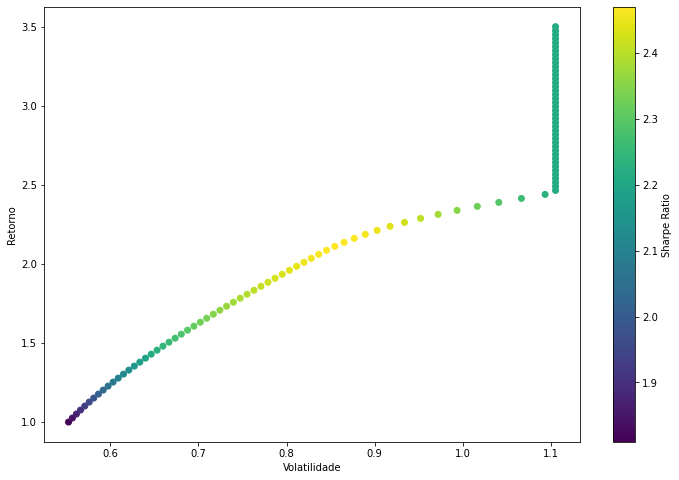

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(frontier_x, frontier_y, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
# plt.scatter(max_sratio_vol, max_sratio_ret, c='red')#, s=50) # red dot
plt.show()

In [8]:
carteiras = pd.DataFrame(columns=simbolos, data=pesos)
carteiras_formatadadas = carteiras.applymap(lambda x: "%.2f" % (x * 100) )

In [9]:
pd.set_option('display.max_rows', None)
print(carteiras_formatadadas)

      BTC   ETH   BNB   ADA  LINK    SOL   DOT   UNI    LUNA   AVAX  ALGO  \
0   58.54  0.00  0.00  0.00  0.00  16.89  0.00  0.00   16.60   0.08  0.00   
1   57.09  0.00  0.00  0.00  0.00  17.55  0.00  0.00   17.16   0.36  0.00   
2   55.65  0.00  0.00  0.00  0.00  18.22  0.00  0.00   17.72   0.63  0.00   
3   54.21  0.00  0.00  0.00  0.00  18.89  0.00  0.00   18.27   0.90  0.00   
4   52.79  0.00  0.00  0.00  0.00  19.54  0.00  0.00   18.81   1.26  0.00   
5   51.36  0.00  0.00  0.00  0.00  20.19  0.00  0.00   19.38   1.56  0.00   
6   49.94  0.00  0.00  0.00  0.00  20.84  0.00  0.00   19.95   1.85  0.00   
7   48.52  0.00  0.00  0.00  0.00  21.49  0.00  0.00   20.52   2.15  0.00   
8   47.10  0.00  0.00  0.00  0.00  22.14  0.00  0.00   21.09   2.45  0.00   
9   45.68  0.00  0.00  0.00  0.00  22.78  0.00  0.00   21.66   2.75  0.00   
10  44.26  0.00  0.00  0.00  0.00  23.43  0.00  0.00   22.23   3.05  0.00   
11  42.84  0.00  0.00  0.00  0.00  24.08  0.00  0.00   22.80   3.35  0.00   

In [10]:
soma = pd.DataFrame(carteiras.sum())
soma.applymap(lambda x: "%.2f" % (x * 100) )

,0
BTC,1231.11
ETH,0.00
BNB,0.00
ADA,0.00
LINK,0.00
SOL,1739.15
DOT,0.00
UNI,0.00
LUNA,6460.65
AVAX,310.85


### Carteira com maior sharpe ratio

In [11]:
max_sharpe_ratio = max(sharpe_ratio)
max_sharpe_index = sharpe_ratio.index(max_sharpe_ratio)
imprimir_resultado(simbolos, pesos[max_sharpe_index])

BTC: 0.00, ETH: 0.00, BNB: 0.00, ADA: 0.00, LINK: 0.00, SOL: 43.67, DOT: 0.00, UNI: 0.00, LUNA: 45.94, AVAX: 10.39, ALGO: 0.00, ATOM: 0.00, EGLD: 0.00, LTC: 0.00, 
